### 2-class

Extracting parameters from data\derivatives\RDM\sub-01_task-rsvp_eeg.vhdr...
Setting channel info structure...
['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'Pz', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', 'AF7', 'AF3', 'AFz', 'F1', 'F5', 'FT7', 'FC3', 'C1', 'C5', 'TP7', 'CP3', 'P1', 'P5', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'P6', 'P2', 'CPz', 'CP4', 'TP8', 'C6', 'C2', 'FC4', 'FT8', 'F6', 'AF8', 'AF4', 'F2', 'FCz']


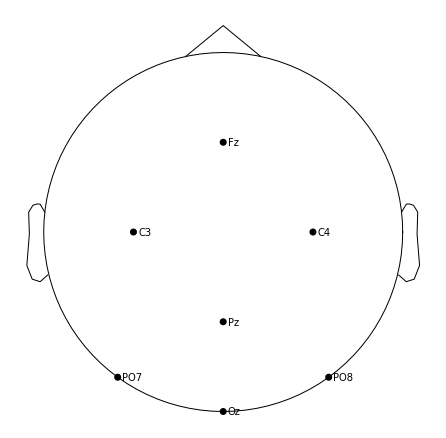

Reading 0 ... 3035739  =      0.000 ...  3035.739 secs...
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 125.00 Hz
- Upper transition bandwidth: 31.25 Hz (-6 dB cutoff frequency: 140.62 Hz)
- Filter length: 6601 samples (6.601

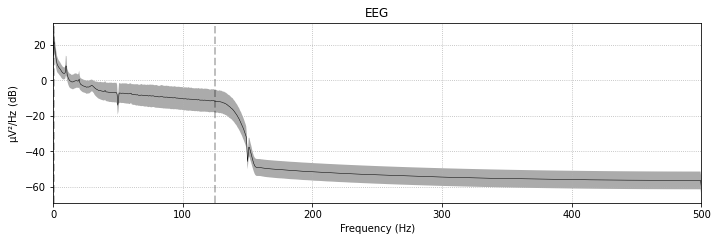

(7, 3035740)

In [94]:
import os
import numpy as np
import pandas as pd
from scipy import fft, signal
from matplotlib import pyplot as plt
from tqdm import tqdm

import networkx as nx

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import cluster, linear_model, svm, neighbors, tree, ensemble

from torch import nn, optim, Tensor, LongTensor

from mne.io import read_raw_brainvision
subject = '01'
data_dir = os.path.join('data', 'derivatives\RDM')
# unicorn_ch_names = ['Fz', 'CPz', 'C3', 'C4', 'Pz', 'PO7', 'PO8', 'Oz']  # wrong ones?
unicorn_ch_names = ['Fz', 'C3', 'C4', 'Pz', 'PO7', 'Oz', 'PO8']  # no 'Cz'
raw = read_raw_brainvision(os.path.join(data_dir, f'sub-{subject}_task-rsvp_eeg.vhdr'))
print(raw.ch_names)

raw.pick_channels(unicorn_ch_names)
raw.plot_sensors(show_names=True);
unicorn_ch_names = raw.ch_names  # the correct arrangement of electrodes in data
raw.load_data()
raw.notch_filter(freqs=[50, 150])  # higher ones are irrelevant because our top is 125 Hz
raw.filter(l_freq=0.5, h_freq=125)
raw.plot_psd(average=True);
data = raw.get_data()
data.shape

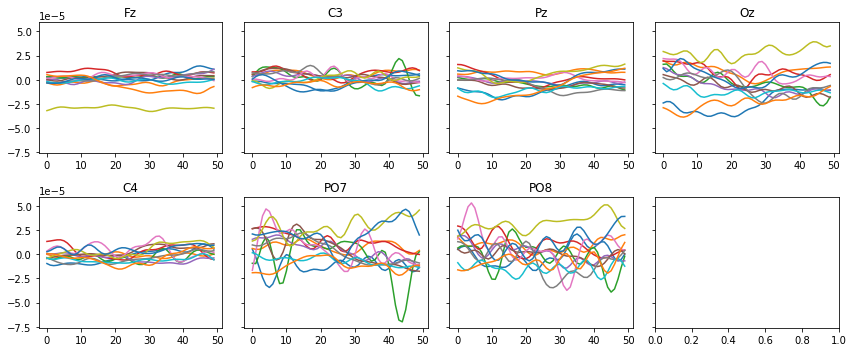

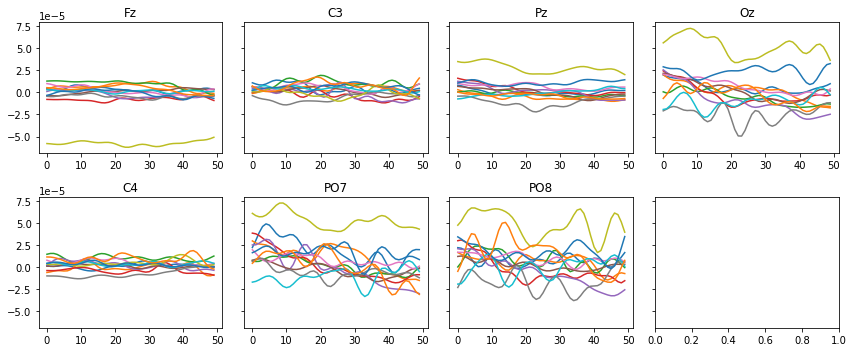

In [95]:
info = pd.read_csv(os.path.join(data_dir, f'sub-{subject}_task-rsvp_events.tsv'), delimiter='\t')
info.head()

chosen_samples = {}

for object_name in ['piano', 'lettuce']:  # change to others
    chosen_samples[object_name] = []
    for i in info[info['object'] == object_name]['onset']:
        chosen_samples[object_name].append(data[:, i: i + 50])
  
    fig, axs = plt.subplots(2, 4, figsize=(12, 5), sharey=True)
    for ch_n, (ch_name, ax) in enumerate(zip(unicorn_ch_names, axs.ravel())):
        ax.set_title(ch_name)
        for s in chosen_samples[object_name]:
            ax.plot(s[ch_n])
    plt.tight_layout()
    plt.show()
    
    
train_sets = {}

samples = np.array([s[4] for s in chosen_samples['piano'] + chosen_samples['lettuce']]) # 4 is Pz
true = np.array([0] * len(chosen_samples['piano']) + [1] * len(chosen_samples['lettuce']))
true_inverse = np.abs(true - 1)
labels = ['piano', 'lettuce']



In [96]:
samples = np.array([s[4] for s in chosen_samples['piano'] + chosen_samples['lettuce']]) # 4 is Pz
true = np.array([0] * len(chosen_samples['piano']) + [1] * len(chosen_samples['lettuce']))
true_inverse = np.abs(true - 1)
labels = ['piano', 'lettuce']
len(samples[0])
# 24 * 50
type(samples)
samples.shape
print(true)

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1]


In [101]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.optimizers import Adam


#Number of classes in the target variable
NB_CLASSES=2
learning_rate = 0.001


X_data = samples
Y_data= true


print("\nFeatures before scaling :\n------------------------------------")
print(X_data[:5,:])
print("\nTarget before scaling :\n------------------------------------")
print(Y_data[:5])

#Create a scaler model that is fit on the input data.
scaler = StandardScaler().fit(X_data)

#Scale the numeric feature variables
X_data = scaler.transform(X_data)

#Convert target variable as a one-hot-encoding array
Y_data = tf.keras.utils.to_categorical(Y_data,NB_CLASSES)



#Split training and test data
X_train,X_test,Y_train,Y_test = train_test_split( X_data, Y_data, test_size=0.10)

print("\nTrain Test Dimensions:\n------------------------------------")
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)






#Create a sequencial model in Keras
model = tf.keras.models.Sequential()

#Add the first hidden layer
model.add(keras.layers.Dense(128,                    #Number of nodes
                             input_shape=(50,),       #Number of input variables
                              name='Hidden-Layer-1', #Logical name
                              activation='relu'))    #activation function

model.add(keras.layers.Dropout(0.2))

#Add a second hidden layer
model.add(keras.layers.Dense(128,
                              name='Hidden-Layer-2',
                              activation='relu'))

model.add(keras.layers.Dropout(0.2))

#Add an output layer with softmax activation
model.add(keras.layers.Dense(NB_CLASSES,
                             name='Output-Layer',
                             activation='softmax'))

#Compile the model with loss & metrics
model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
              metrics=['accuracy'])

#Print the model meta-data
model.summary()

print(Y_train)



Features before scaling :
------------------------------------
[[-9.52187448e-06 -1.11824622e-05 -1.16799883e-05 -1.12957009e-05
  -1.04869246e-05 -9.68149333e-06 -9.14400138e-06 -8.96032026e-06
  -9.10079162e-06 -9.48874392e-06 -1.00278201e-05 -1.05873924e-05
  -1.09884378e-05 -1.10387471e-05 -1.06142301e-05 -9.73202917e-06
  -8.56461857e-06 -7.37259814e-06 -6.37950637e-06 -5.65978187e-06
  -5.11198614e-06 -4.52921780e-06 -3.72002415e-06 -2.61319590e-06
  -1.29104858e-06  5.89207897e-08  1.23569177e-06  2.10836299e-06
   2.65425288e-06  2.94678371e-06  3.11908432e-06  3.32317483e-06
   3.68244068e-06  4.23823097e-06  4.91084384e-06  5.49881227e-06
   5.73781438e-06  5.42265883e-06  4.55086298e-06  3.40290632e-06
   2.48969860e-06  2.36075588e-06  3.34258862e-06  5.33544575e-06
   7.78559146e-06  9.86841674e-06  1.08143403e-05  1.02289162e-05
   8.25438671e-06  5.49637172e-06]
 [ 3.76581894e-08 -9.97540728e-07 -2.21053116e-06 -3.07702009e-06
  -3.26265896e-06 -2.76338527e-06 -1.862022

C:\Users\lizen\anaconda3\envs\magenta\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)



Training Progress:
------------------------------------
Epoch 1/10
1/1 [==============================] - 1s 518ms/step - loss: 0.6816 - accuracy: 0.3750 - val_loss: 0.6252 - val_accuracy: 0.6000
Epoch 2/10
1/1 [==============================] - 0s 84ms/step - loss: 0.7222 - accuracy: 0.3750 - val_loss: 0.5923 - val_accuracy: 0.6000
Epoch 3/10
1/1 [==============================] - 0s 83ms/step - loss: 0.5512 - accuracy: 0.6250 - val_loss: 0.5685 - val_accuracy: 0.6000
Epoch 4/10
1/1 [==============================] - 0s 74ms/step - loss: 0.4668 - accuracy: 0.8750 - val_loss: 0.5488 - val_accuracy: 0.6000
Epoch 5/10
1/1 [==============================] - 0s 76ms/step - loss: 0.5243 - accuracy: 0.6875 - val_loss: 0.5392 - val_accuracy: 0.6000
Epoch 6/10
1/1 [==============================] - 0s 76ms/step - loss: 0.5182 - accuracy: 0.8750 - val_loss: 0.5272 - val_accuracy: 0.6000
Epoch 7/10
1/1 [==============================] - 0s 73ms/step - loss: 0.4759 - accuracy: 0.8750 - val_loss:

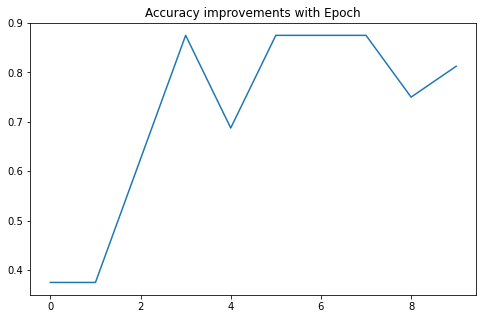


Evaluation against Test Dataset :
------------------------------------
1/1 [==============================] - 0s 48ms/step - loss: 0.2524 - accuracy: 1.0000


[0.25241395831108093, 1.0]

In [102]:
#Make it verbose so we can see the progress
VERBOSE=1

#Setup Hyper Parameters for training

#Set Batch size
BATCH_SIZE=16
#Set number of epochs
EPOCHS=10
#Set validation split. 20% of the training data will be used for validation
#after each epoch
VALIDATION_SPLIT=0.2

print("\nTraining Progress:\n------------------------------------")

#Fit the model. This will perform the entire training cycle, including
#forward propagation, loss computation, backward propagation and gradient descent.
#Execute for the specified batch sizes and epoch
#Perform validation after each epoch 
history=model.fit(X_train,
          Y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=VERBOSE,
          validation_split=VALIDATION_SPLIT)

print("\nAccuracy during Training :\n------------------------------------")
import matplotlib.pyplot as plt

#Plot accuracy of the model after each epoch.
pd.DataFrame(history.history)["accuracy"].plot(figsize=(8, 5))
plt.title("Accuracy improvements with Epoch")
plt.show()

#Evaluate the model against the test dataset and print results
print("\nEvaluation against Test Dataset :\n------------------------------------")
model.evaluate(X_test,Y_test)

## Prediction on another subject

In [103]:
labels = ["piano", "lettuce"] #{0:"piano",1:"lettuce"}
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(labels) 


import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import column_or_1d

class MyLabelEncoder(LabelEncoder):

    def fit(self, y):
        y = column_or_1d(y, warn=True)
        self.classes_ = pd.Series(y).unique()
        return self
    
le = MyLabelEncoder()
le.fit(labels)
le.classes_

print(le.transform(["piano"]))
print(le.inverse_transform([0]))

[0]
['piano']


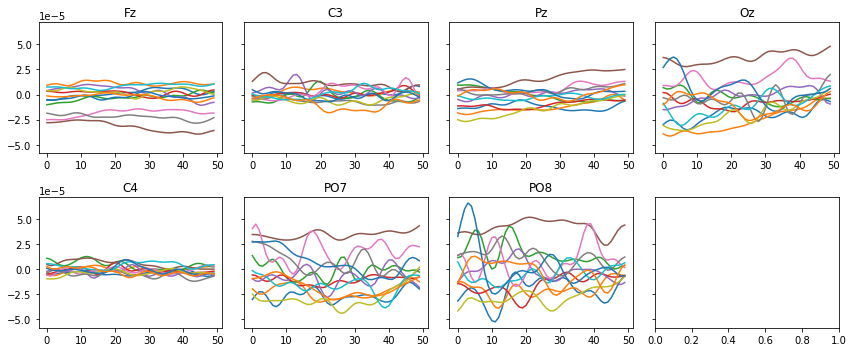

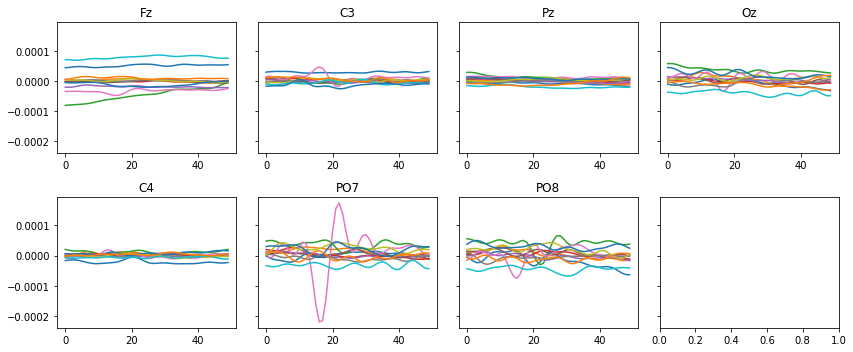

In [104]:
subject = '02'

info = pd.read_csv(os.path.join(data_dir, f'sub-{subject}_task-rsvp_events.tsv'), delimiter='\t')
info.head()

chosen_samples2 = {}

for object_name in ['piano', 'lettuce']:  # change to others
    chosen_samples2[object_name] = []
    for i in info[info['object'] == object_name]['onset']:
        chosen_samples2[object_name].append(data[:, i: i + 50])
  
    fig, axs = plt.subplots(2, 4, figsize=(12, 5), sharey=True)
    for ch_n, (ch_name, ax) in enumerate(zip(unicorn_ch_names, axs.ravel())):
        ax.set_title(ch_name)
        for s in chosen_samples2[object_name]:
            ax.plot(s[ch_n])
    plt.tight_layout()
    plt.show()
    
    
train_sets = {}




In [105]:
prediction_inputs = np.array([s[4] for s in chosen_samples2['piano']]) # + chosen_samples['lettuce']]) # 4 is Pz

for i in prediction_inputs :
#Raw prediction data
    prediction_input = [i]

    #Scale prediction data with the same scaling model
    scaled_input = scaler.transform(prediction_input)

    #Get raw prediction probabilities
    raw_prediction = model.predict(scaled_input)
    print("Raw Prediction Output (Probabilities) :" , raw_prediction)

    #Find prediction
    prediction = np.argmax(raw_prediction) #, axis=1)

    print("pred = ", prediction)
    print("Prediction is ", le.inverse_transform([prediction]))


Raw Prediction Output (Probabilities) : [[0.5842821  0.41571787]]
pred =  0
Prediction is  ['piano']
Raw Prediction Output (Probabilities) : [[0.5040795  0.49592048]]
pred =  0
Prediction is  ['piano']
Raw Prediction Output (Probabilities) : [[0.20733647 0.7926635 ]]
pred =  1
Prediction is  ['lettuce']
Raw Prediction Output (Probabilities) : [[0.4590406  0.54095936]]
pred =  1
Prediction is  ['lettuce']
Raw Prediction Output (Probabilities) : [[0.6169817 0.3830183]]
pred =  0
Prediction is  ['piano']
Raw Prediction Output (Probabilities) : [[0.10232712 0.8976729 ]]
pred =  1
Prediction is  ['lettuce']
Raw Prediction Output (Probabilities) : [[0.5440988  0.45590127]]
pred =  0
Prediction is  ['piano']
Raw Prediction Output (Probabilities) : [[0.6762143  0.32378572]]
pred =  0
Prediction is  ['piano']
Raw Prediction Output (Probabilities) : [[0.5029698  0.49703023]]
pred =  0
Prediction is  ['piano']
Raw Prediction Output (Probabilities) : [[0.50426674 0.4957333 ]]
pred =  0
Prediction 

## n-class

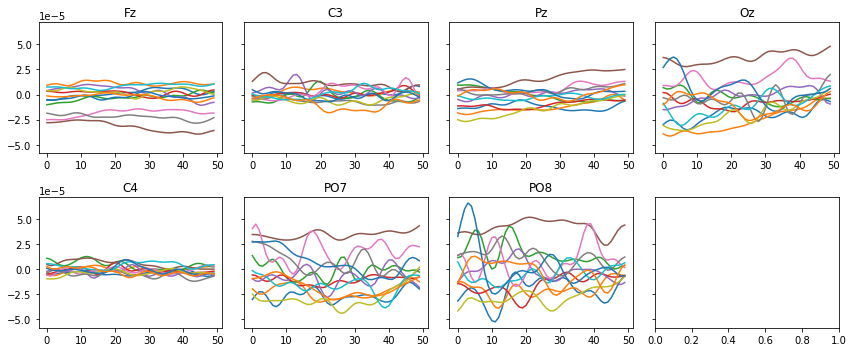

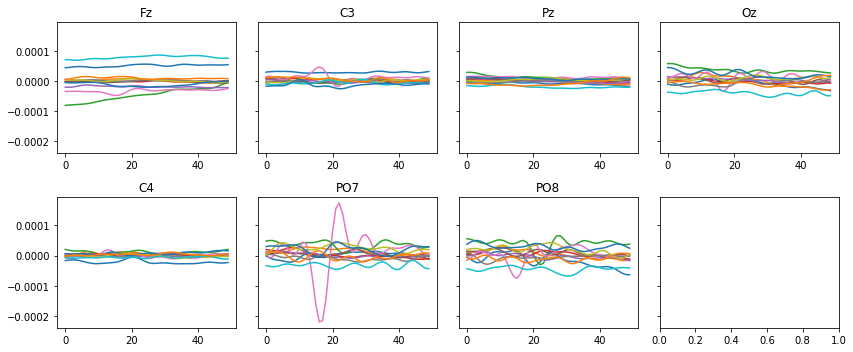

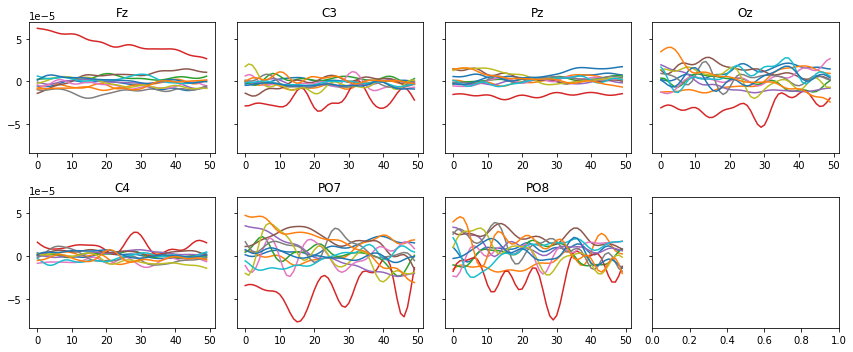

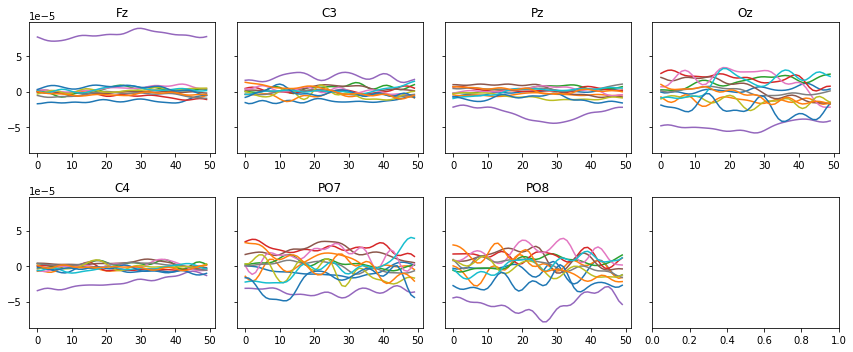

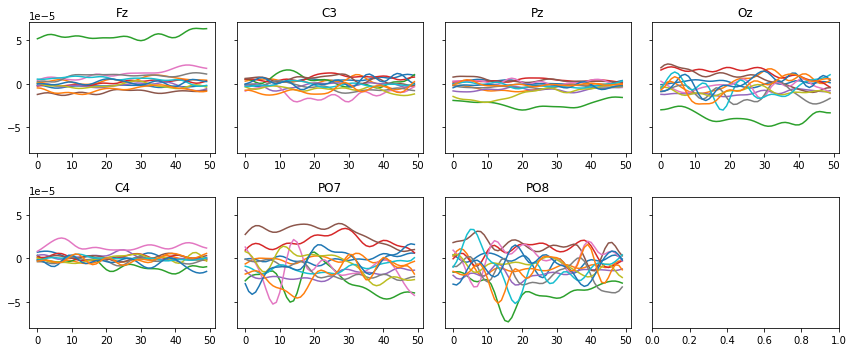

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 3
 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4]


In [106]:
info = pd.read_csv(os.path.join(data_dir, f'sub-{subject}_task-rsvp_events.tsv'), delimiter='\t')
info.head()

chosen_samples = {}

for object_name in ['piano', 'lettuce', 'apple', 'amplifier', 'alligator']:  # change to others
    chosen_samples[object_name] = []
    for i in info[info['object'] == object_name]['onset']:
        chosen_samples[object_name].append(data[:, i: i + 50])
  
    fig, axs = plt.subplots(2, 4, figsize=(12, 5), sharey=True)
    for ch_n, (ch_name, ax) in enumerate(zip(unicorn_ch_names, axs.ravel())):
        ax.set_title(ch_name)
        for s in chosen_samples[object_name]:
            ax.plot(s[ch_n])
    plt.tight_layout()
    plt.show()
    
    
train_sets = {}

samples = np.array([s[4] for s in chosen_samples['piano'] + chosen_samples['lettuce'] + chosen_samples['apple'] + chosen_samples['amplifier'] + chosen_samples['alligator']]) # 4 is Pz
true = np.array([0] * len(chosen_samples['piano']) + [1] * len(chosen_samples['lettuce']) + [2] * len(chosen_samples['apple']) + [3] * len(chosen_samples['amplifier']) + [4] * len(chosen_samples['alligator']))
#true_inverse = np.abs(true - 1)
labels = ['piano', 'lettuce','apple', 'amplifier', 'alligator']

print(true)

In [ ]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.optimizers import Adam


#Number of classes in the target variable
NB_CLASSES=5
learning_rate = 0.001


X_data = samples
Y_data= true



#Create a scaler model that is fit on the input data.
scaler = StandardScaler().fit(X_data)

#Scale the numeric feature variables
X_data = scaler.transform(X_data)

#Convert target variable as a one-hot-encoding array
Y_data = tf.keras.utils.to_categorical(Y_data,NB_CLASSES)


#Split training and test data
X_train,X_test,Y_train,Y_test = train_test_split( X_data, Y_data, test_size=0.10)

print("\nTrain Test Dimensions:\n------------------------------------")
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)






#Create a sequencial model in Keras
model = tf.keras.models.Sequential()

#Add the first hidden layer
model.add(keras.layers.Dense(128*2,                    #Number of nodes
                             input_shape=(50,),       #Number of input variables
                              name='Hidden-Layer-1', #Logical name
                              activation='relu'))    #activation function

#Add a second hidden layer
model.add(keras.layers.Dense(128,
                              name='Hidden-Layer-2',
                              activation='relu'))
model.add(keras.layers.Dropout(0.2))

#Add an output layer with softmax activation
model.add(keras.layers.Dense(NB_CLASSES,
                             name='Output-Layer',
                             activation='softmax'))

#Compile the model with loss & metrics
model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
              metrics=['accuracy'])

#Print the model meta-data
model.summary()

print(Y_train)


In [ ]:
#Make it verbose so we can see the progress
VERBOSE=1

#Setup Hyper Parameters for training

#Set Batch size
BATCH_SIZE=16
#Set number of epochs
EPOCHS=10
#Set validation split. 20% of the training data will be used for validation
#after each epoch
VALIDATION_SPLIT=0.2

print("\nTraining Progress:\n------------------------------------")

#Fit the model. This will perform the entire training cycle, including
#forward propagation, loss computation, backward propagation and gradient descent.
#Execute for the specified batch sizes and epoch
#Perform validation after each epoch 
history=model.fit(X_train,
          Y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=VERBOSE,
          validation_split=VALIDATION_SPLIT)

print("\nAccuracy during Training :\n------------------------------------")
import matplotlib.pyplot as plt

#Plot accuracy of the model after each epoch.
pd.DataFrame(history.history)["accuracy"].plot(figsize=(8, 5))
plt.title("Accuracy improvements with Epoch")
plt.show()

#Evaluate the model against the test dataset and print results
print("\nEvaluation against Test Dataset :\n------------------------------------")
model.evaluate(X_test,Y_test)

## all channels

In [6]:
samples = np.array([s for s in chosen_samples['piano'] + chosen_samples['lettuce']]) # 4 is Pz
true = np.array([0] * len(chosen_samples['piano']) + [1] * len(chosen_samples['lettuce']))
true_inverse = np.abs(true - 1)
labels = ['piano', 'lettuce']
# 24 * 7 * 50

print(type(samples))
samples.shape



<class 'numpy.ndarray'>


(24, 7, 50)

In [ ]:
import pandas as pd
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.optimizers import Adam


#Number of classes in the target variable
NB_CLASSES=2
learning_rate = 0.001


X_data = samples
Y_data= true


print("\nFeatures before scaling :\n------------------------------------")
print(X_data[:5,:])
print("\nTarget before scaling :\n------------------------------------")
print(Y_data[:5])

'''
#Create a scaler model that is fit on the input data.
scaler = StandardScaler().fit(X_data)

#Scale the numeric feature variables
X_data = scaler.transform(X_data)
'''

# Scale 3d array 

scalers = {}
for i in range(X_data.shape[1]):
    scalers[i] = StandardScaler()
    X_data[:, i, :] = scalers[i].fit_transform(X_data[:, i, :]) 

#Convert target variable as a one-hot-encoding array
Y_data = tf.keras.utils.to_categorical(Y_data,NB_CLASSES)


#Split training and test data
X_train,X_test,Y_train,Y_test = train_test_split( X_data, Y_data, test_size=0.10)

print("\nTrain Test Dimensions:\n------------------------------------")
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)






#Create a sequencial model in Keras
model = tf.keras.models.Sequential()

#Add the first hidden layer
model.add(keras.layers.Dense(128,                    #Number of nodes
                             input_shape=(7,50,),       #Number of input variables
                              name='Hidden-Layer-1', #Logical name
                              activation='relu'))    #activation function

#Add a second hidden layer
model.add(keras.layers.Dense(128,
                              name='Hidden-Layer-2',
                              activation='relu'))

#Add an output layer with softmax activation
model.add(keras.layers.Dense(NB_CLASSES,
                             name='Output-Layer',
                             activation='softmax'))

#Compile the model with loss & metrics
model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy',
              metrics=['accuracy'])

#Print the model meta-data
model.summary()

print(Y_train)


In [ ]:
#Make it verbose so we can see the progress
VERBOSE=1

#Setup Hyper Parameters for training

#Set Batch size
BATCH_SIZE=16
#Set number of epochs
EPOCHS=10
#Set validation split. 20% of the training data will be used for validation
#after each epoch
VALIDATION_SPLIT=0.2

print("\nTraining Progress:\n------------------------------------")

#Fit the model. This will perform the entire training cycle, including
#forward propagation, loss computation, backward propagation and gradient descent.
#Execute for the specified batch sizes and epoch
#Perform validation after each epoch 
history=model.fit(X_train,
          Y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          verbose=VERBOSE,
          validation_split=VALIDATION_SPLIT)

print("\nAccuracy during Training :\n------------------------------------")
import matplotlib.pyplot as plt

#Plot accuracy of the model after each epoch.
pd.DataFrame(history.history)["accuracy"].plot(figsize=(8, 5))
plt.title("Accuracy improvements with Epoch")
plt.show()

#Evaluate the model against the test dataset and print results
print("\nEvaluation against Test Dataset :\n------------------------------------")
model.evaluate(X_test,Y_test)

### LSTM classification  THINGS-EEG

In [ ]:
samples = np.array([s for s in chosen_samples['piano'] + chosen_samples['lettuce']]) # 4 is Pz
true = np.array([0] * len(chosen_samples['piano']) + [1] * len(chosen_samples['lettuce']))
true_inverse = np.abs(true - 1)
labels = ['piano', 'lettuce']
# 24 * 7 * 50

print(type(samples))
samples.shape



In [ ]:


import tensorflow as tf
from tensorflow.keras.optimizers import Adam


X=samples.reshape((24, 50, 7))

# sample, time steps, and feature 
print(X)
y=true


from sklearn.preprocessing import normalize

print("Shape of X",X.shape)
print("Shape of y",y.shape)
print("Examples of X\n",X[:3])
print("Examples of y\n",y[:3])

print(len(y))

#X_normalized=normalize(X,axis=0)

total_length=len(X)
train_length=int(0.8*total_length)
test_length=int(0.2*total_length)

X_train=X[:train_length]
X_test=X[train_length:]
y_train=y[:train_length]
y_test=y[train_length:]

print("Length of train set x:",X_train.shape[0],"y:",y_train.shape[0])
print("Length of test set x:",X_test.shape[0],"y:",y_test.shape[0])



#Neural network module
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense,Activation,Dropout 
from keras.layers import BatchNormalization 
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.optimizers import RMSprop

n_classes=2
dropout = 0.2
# Training batch size
batch_size = 40
# Learning rate
learning_rate = 0.001
input_shape = (24,50,1)


y_train=np_utils.to_categorical(y_train,num_classes=n_classes)
y_test=np_utils.to_categorical(y_test,num_classes=n_classes)
print("Shape of y_train",y_train.shape)
print("Shape of y_test",y_test.shape)


time_point = 12 
features = 50 

model=Sequential()
model.add(LSTM(512, input_shape=(50, 7), name='LSTM', return_sequences=True)) #,  return_sequences=True input_shape=(time_point, features),
model.add(Dropout(dropout))
model.add(LSTM(256, name='LSTM2', return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(128, name='LSTM3'))
model.add(Dropout(dropout))
model.add(Dense(64, activation=tf.nn.tanh))
model.add(Dense(2, activation='softmax'))

    
# Compile the model with appropriate loss for multiclass classification
model.compile(optimizer=Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['acc']) #Adam(lr=learning_rate)

model.summary()

model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=batch_size,epochs=50,verbose=1)

#https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/